# **1. Load Packages**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os, glob
import geopandas as gpd
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import LinearSegmentedColormap
import tqdm

from matplotlib.colors import ListedColormap
from matplotlib import cm
import matplotlib.dates as mdates
import re
import calendar

import datetime as dt
from pathlib import Path
from tqdm import tqdm

# **2. Transfer: Merge the data to yearly average**

In [ ]:
out_dir = "../plot_trend_XCO2"
os.makedirs(out_dir, exist_ok=True)

def load_year_mean(folder, year):
    files = sorted(glob(f"{folder}/monthly_xco2_full_{year}_*.npy"))
    if not files:
        raise FileNotFoundError(f"No .npy files for year {year} under {folder}")

    dfs = []
    for f in tqdm(files, desc=f"Loading {year}", unit="file"):
        arr = np.load(f, allow_pickle=True)

        if isinstance(arr, dict):
            df = pd.DataFrame(arr)
        elif getattr(arr, "dtype", None) is not None and arr.dtype.names is not None:
            df = pd.DataFrame(arr)
        else:
            df = pd.DataFrame(list(arr))

        need = ["lat", "lon", "time", "xco2_pred"]
        df = df[[c for c in need if c in df.columns]].copy()
        df["time"] = pd.to_datetime(df["time"])
        df = df[df["time"].dt.year == year]
        dfs.append(df)

    allm = pd.concat(dfs, ignore_index=True)

    mean_year = (allm
                 .groupby(["lat", "lon"], as_index=False)["xco2_pred"]
                 .mean()
                 .rename(columns={"xco2_pred": f"xco2_{year}"}))
    return mean_year

folder = "../XCO2_prediction_full"

mean_2019 = load_year_mean(folder, 2019)
out_path = os.path.join(out_dir, "mean_2019.npy")
np.save(out_path, mean_2019.to_records(index=False))

mean_2020 = load_year_mean(folder, 2020)
out_path = os.path.join(out_dir, "mean_2020.npy")
np.save(out_path, mean_2020.to_records(index=False))

mean_2021 = load_year_mean(folder, 2021)
out_path = os.path.join(out_dir, "mean_2021.npy")
np.save(out_path, mean_2021.to_records(index=False))

mean_2022 = load_year_mean(folder, 2022)
out_path = os.path.join(out_dir, "mean_2022.npy")
np.save(out_path, mean_2022.to_records(index=False))

mean_2023 = load_year_mean(folder, 2023)
out_path = os.path.join(out_dir, "mean_2023.npy")
np.save(out_path, mean_2023.to_records(index=False))

mean_2024 = load_year_mean(folder, 2024)
out_path = os.path.join(out_dir, "mean_2024.npy")
np.save(out_path, mean_2024.to_records(index=False))

In [ ]:
out_dir = "../plot_trend_XCO2"
os.makedirs(out_dir, exist_ok=True)

def load_year_mean(folder, year, months=None):
    files = sorted(glob(f"{folder}/monthly_xco2_full_{year}_*.npy"))
    if not files:
        raise FileNotFoundError(f"No .npy files for year {year} under {folder}")
    dfs = []
    for f in tqdm(files, desc=f"Loading {year}", unit="file"):
        arr = np.load(f, allow_pickle=True)
        if isinstance(arr, dict):
            df = pd.DataFrame(arr)
        elif getattr(arr, "dtype", None) is not None and arr.dtype.names is not None:
            df = pd.DataFrame(arr)
        else:
            df = pd.DataFrame(list(arr))
        need = ["lat", "lon", "time", "xco2_pred"]
        df = df[[c for c in need if c in df.columns]].copy()
        df["time"] = pd.to_datetime(df["time"])
        mask = df["time"].dt.year == year
        if months is not None:
            months = list(months)
            mask &= df["time"].dt.month.isin(months)
        df = df[mask]

        if not df.empty:
            dfs.append(df)

    if not dfs:
        raise ValueError(f"No data left for year {year} with months={months}")

    allm = pd.concat(dfs, ignore_index=True)
    if months is None:
        colname = f"xco2_{year}"
    else:
        m_str = "_".join(f"{m:02d}" for m in sorted(set(months)))
        colname = f"xco2_{year}_m{m_str}"

    mean_year = (
        allm.groupby(["lat", "lon"], as_index=False)["xco2_pred"]
            .mean()
            .rename(columns={"xco2_pred": colname})
    )
    return mean_year

folder = "../XCO2_prediction_full"

mean_2025_JanJun = load_year_mean(folder, 2025, months=range(1, 6))
out_path = os.path.join(out_dir, "mean_2025_JanMay.npy")
np.save(out_path, mean_2025_JanJun.to_records(index=False))

# **3. Plot Figures (Yearly change)**

## **3.1 Plot 5-year average: (2024-2019)/5**

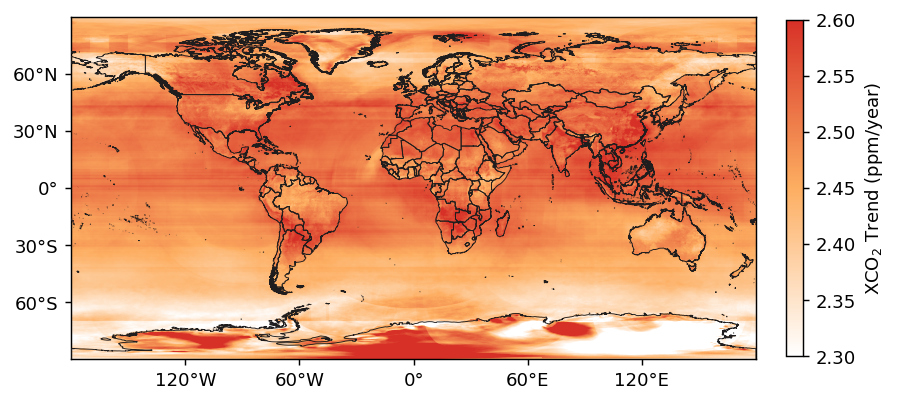

In [18]:
def load_mean_year(year, folder="../plot_trend_XCO2"):
    path = os.path.join(folder, f"mean_{year}.npy")
    arr = np.load(path, allow_pickle=True)
    df = pd.DataFrame.from_records(arr)
    for c in ["lat", "lon", f"xco2_{year}"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
        else:
            raise ValueError(f"{path} Lack: {c}")
    return df

mean_2019 = load_mean_year(2019)
mean_2020 = load_mean_year(2024)

merged = mean_2019.merge(mean_2020, on=["lat", "lon"], how="inner")
merged["trend_ppm_per_year"] = (merged["xco2_2024"] - merged["xco2_2019"]) /5 
grid = merged.pivot(index="lat", columns="lon", values="trend_ppm_per_year").sort_index()

world = gpd.read_file("../world/admin_world_country.shp")
world = world.set_crs(epsg=4326) if world.crs is None else world.to_crs(epsg=4326)

lat_vals = grid.index.values
lon_vals = grid.columns.values

def fmt_lon(x, pos):
    if np.isnan(x): 
        return ""
    if x == 0:
        return "0°"
    hemi = "W" if x < 0 else "E"
    return f"{abs(x):.0f}°{hemi}"

def fmt_lat(y, pos):
    if np.isnan(y): 
        return ""
    if y == 0:
        return "0°"
    hemi = "S" if y < 0 else "N"
    return f"{abs(y):.0f}°{hemi}"

lon_formatter = FuncFormatter(fmt_lon)
lat_formatter = FuncFormatter(fmt_lat)

def nice_ticks(vmin, vmax, step):
    start = np.ceil(vmin / step) * step
    end   = np.floor(vmax / step) * step
    return np.arange(start, end + 1e-9, step)

xticks = nice_ticks(lon_vals.min(), lon_vals.max(), 60) 
yticks = nice_ticks(lat_vals.min(), lat_vals.max(), 30) 

fig, ax = plt.subplots(figsize=(7.0, 4), dpi=130)

colors = ["#FFFFFF","#fdae61","#d73027"]
#colors = ["#FFFFFF","#fdae61","#d73027"]
cmap = LinearSegmentedColormap.from_list("w-b-g-y-o-r", colors, N=256)

im = ax.imshow(
    grid.values, origin="lower",
    extent=[lon_vals.min(), lon_vals.max(), lat_vals.min(), lat_vals.max()],
    aspect="auto",
    cmap=cmap, zorder=1, vmin=2.3, vmax=2.6
)

world.plot(ax=ax, color="none", edgecolor="#1F1D1D", linewidth=0.5, zorder=3)
cb = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, shrink=0.7)
cb.set_label("XCO$_2$ Trend (ppm/year)")

ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

ax.set_xlabel("")
ax.set_ylabel("")

ax.set_xlim(lon_vals.min(), lon_vals.max())
ax.set_ylim(lat_vals.min(), lat_vals.max())
ax.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()

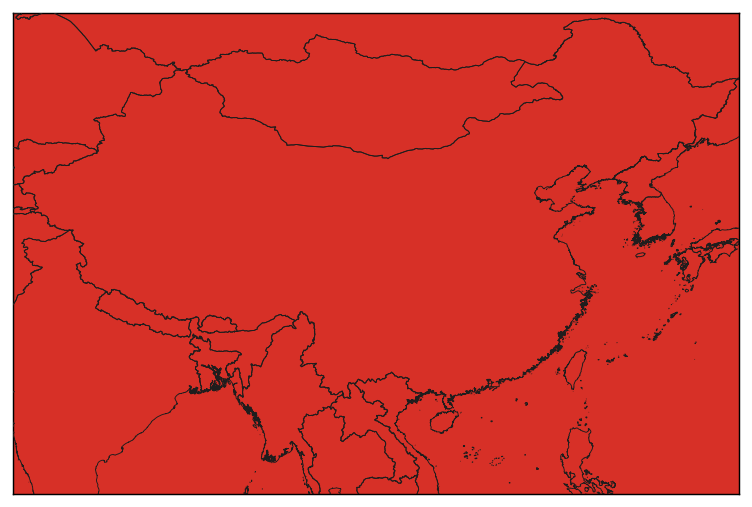

In [ ]:
fig, ax = plt.subplots(figsize=(7.0, 4), dpi=130)

colors = ["#FFFFFF","#fdae61","#d73027"]
#colors = ["#FFFFFF","#fdae61","#d73027"]
cmap = LinearSegmentedColormap.from_list("w-b-g-y-o-r", colors, N=256)

im = ax.imshow(
    grid.values, origin="lower",
    extent=[lon_vals.min(), lon_vals.max(), lat_vals.min(), lat_vals.max()],
    aspect="auto",
    cmap=cmap, zorder=1, vmin=2.3, vmax=2.6
)

world.plot(ax=ax, color="none", edgecolor="#1F1D1D", linewidth=0.5, zorder=3)

ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

ax.set_xlim(lon_vals.min(), lon_vals.max())
ax.set_ylim(lat_vals.min(), lat_vals.max())
ax.tick_params(axis='both', which='major', labelsize=10)

lon_min, lon_max = 73, 135
lat_min, lat_max = 13, 54
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)

ax.set_xlabel("")
ax.set_ylabel("")

ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.show()

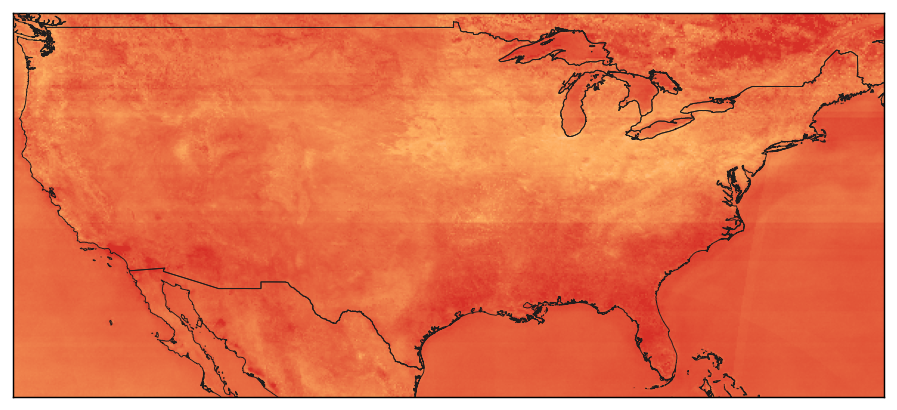

In [11]:
fig, ax = plt.subplots(figsize=(7.0, 4), dpi=130)

colors = ["#FFFFFF","#fdae61","#d73027"]
#colors = ["#FFFFFF","#fdae61","#d73027"]
cmap = LinearSegmentedColormap.from_list("w-b-g-y-o-r", colors, N=256)

im = ax.imshow(
    grid.values, origin="lower",
    extent=[lon_vals.min(), lon_vals.max(), lat_vals.min(), lat_vals.max()],
    aspect="auto",
    cmap=cmap, zorder=1, vmin=2.3, vmax=2.6
)

world.plot(ax=ax, color="none", edgecolor="#1F1D1D", linewidth=0.5, zorder=3)

ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

ax.set_xlim(lon_vals.min(), lon_vals.max())
ax.set_ylim(lat_vals.min(), lat_vals.max())
ax.tick_params(axis='both', which='major', labelsize=10)

lon_min, lon_max = -125, -66
lat_min, lat_max = 24, 50
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)

ax.set_xlabel("")
ax.set_ylabel("")

ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.show()

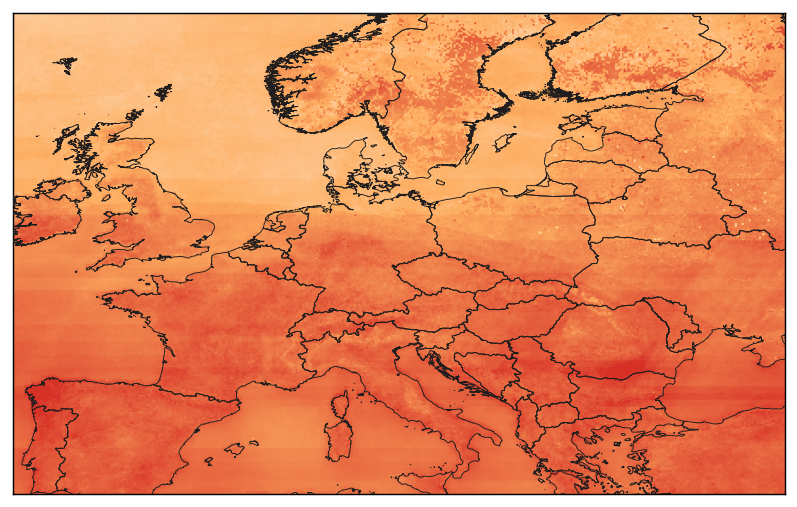

In [16]:
fig, ax = plt.subplots(figsize=(7.0, 4), dpi=130)

colors = ["#FFFFFF","#fdae61","#d73027"]
#colors = ["#FFFFFF","#fdae61","#d73027"]
cmap = LinearSegmentedColormap.from_list("w-b-g-y-o-r", colors, N=256)

im = ax.imshow(
    grid.values, origin="lower",
    extent=[lon_vals.min(), lon_vals.max(), lat_vals.min(), lat_vals.max()],
    aspect="auto",
    cmap=cmap, zorder=1, vmin=2.3, vmax=2.6
)

world.plot(ax=ax, color="none", edgecolor="#1F1D1D", linewidth=0.5, zorder=3)

ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

ax.set_xlim(lon_vals.min(), lon_vals.max())
ax.set_ylim(lat_vals.min(), lat_vals.max())
ax.tick_params(axis='both', which='major', labelsize=10)

lon_min, lon_max = -10, 35
lat_min, lat_max = 37, 65
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)

ax.set_xlabel("")
ax.set_ylabel("")

ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.show()

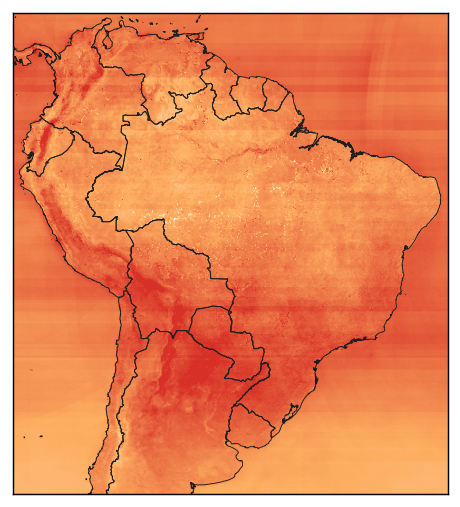

In [13]:
fig, ax = plt.subplots(figsize=(7.0, 4), dpi=130)

colors = ["#FFFFFF","#fdae61","#d73027"]
#colors = ["#FFFFFF","#fdae61","#d73027"]
cmap = LinearSegmentedColormap.from_list("w-b-g-y-o-r", colors, N=256)

im = ax.imshow(
    grid.values, origin="lower",
    extent=[lon_vals.min(), lon_vals.max(), lat_vals.min(), lat_vals.max()],
    aspect="auto",
    cmap=cmap, zorder=1, vmin=2.3, vmax=2.6
)

world.plot(ax=ax, color="none", edgecolor="#1F1D1D", linewidth=0.5, zorder=3)

ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

ax.set_xlim(lon_vals.min(), lon_vals.max())
ax.set_ylim(lat_vals.min(), lat_vals.max())
ax.tick_params(axis='both', which='major', labelsize=10)

lon_min, lon_max = -82, -34   
lat_min, lat_max = -40, 13
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)

ax.set_xlabel("")
ax.set_ylabel("")

ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.show()

### **3.1.x Plot 2024 - mean(2019-2023)**

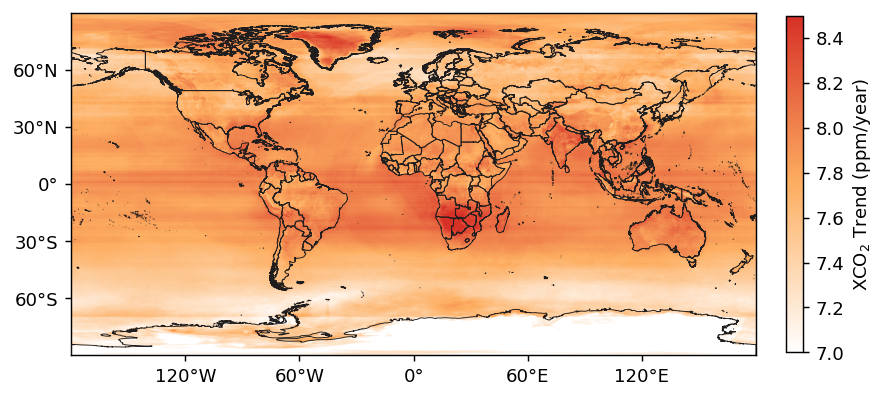

In [ ]:
def load_mean_year(year, folder="../plot_trend_XCO2"):
    path = os.path.join(folder, f"mean_{year}.npy")
    arr = np.load(path, allow_pickle=True)
    df = pd.DataFrame.from_records(arr)
    for c in ["lat", "lon", f"xco2_{year}"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
        else:
            raise ValueError(f"{path} Lack: {c}")
    return df

def load_mean_multi_year(years, folder="../plot_trend_XCO2"):
    dfs = []
    for y in years:
        df = load_mean_year(y, folder)
        df = df.rename(columns={f"xco2_{y}": f"xco2"})
        df["year"] = y
        dfs.append(df)

    all_df = pd.concat(dfs, ignore_index=True)

    mean_df = (
        all_df
        .groupby(["lat", "lon"], as_index=False)["xco2"]
        .mean()
        .rename(columns={"xco2": "xco2_mean_2019_2023"})
    )
    return mean_df


mean_2019_2023 = load_mean_multi_year(range(2019, 2024))
mean_2024 = load_mean_year(2024)

merged = mean_2019_2023.merge(
    mean_2024,
    on=["lat", "lon"],
    how="inner"
)

merged["trend_ppm_per_year"] = (
    merged["xco2_2024"] - merged["xco2_mean_2019_2023"]
)

grid = merged.pivot(index="lat", columns="lon", values="trend_ppm_per_year").sort_index()

world = gpd.read_file("../world/admin_world_country.shp")
world = world.set_crs(epsg=4326) if world.crs is None else world.to_crs(epsg=4326)

lat_vals = grid.index.values
lon_vals = grid.columns.values

def fmt_lon(x, pos):
    if np.isnan(x): 
        return ""
    if x == 0:
        return "0°"
    hemi = "W" if x < 0 else "E"
    return f"{abs(x):.0f}°{hemi}"

def fmt_lat(y, pos):
    if np.isnan(y): 
        return ""
    if y == 0:
        return "0°"
    hemi = "S" if y < 0 else "N"
    return f"{abs(y):.0f}°{hemi}"

lon_formatter = FuncFormatter(fmt_lon)
lat_formatter = FuncFormatter(fmt_lat)

def nice_ticks(vmin, vmax, step):
    start = np.ceil(vmin / step) * step
    end   = np.floor(vmax / step) * step
    return np.arange(start, end + 1e-9, step)

xticks = nice_ticks(lon_vals.min(), lon_vals.max(), 60) 
yticks = nice_ticks(lat_vals.min(), lat_vals.max(), 30) 

fig, ax = plt.subplots(figsize=(7.0, 4), dpi=130)

colors = ["#FFFFFF","#fdae61","#d73027"]
#colors = ["#FFFFFF","#fdae61","#d73027"]
cmap = LinearSegmentedColormap.from_list("w-b-g-y-o-r", colors, N=256)

im = ax.imshow(
    grid.values, origin="lower",
    extent=[lon_vals.min(), lon_vals.max(), lat_vals.min(), lat_vals.max()],
    aspect="auto",
    cmap=cmap, zorder=1, vmin=7, vmax=8.5
)

world.plot(ax=ax, color="none", edgecolor="#1F1D1D", linewidth=0.5, zorder=3)
cb = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, shrink=0.7)
cb.set_label("XCO$_2$ Trend (ppm/year)")

ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

ax.set_xlabel("")
ax.set_ylabel("")

ax.set_xlim(lon_vals.min(), lon_vals.max())
ax.set_ylim(lat_vals.min(), lat_vals.max())
ax.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()

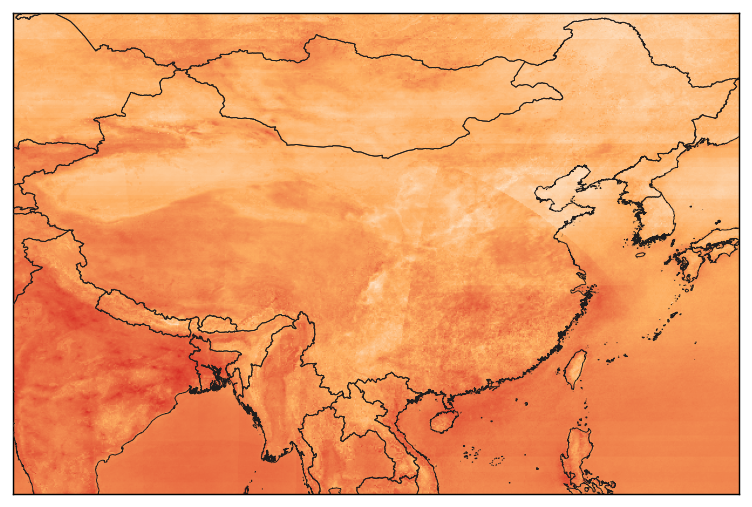

In [30]:
fig, ax = plt.subplots(figsize=(7.0, 4), dpi=130)

colors = ["#FFFFFF","#fdae61","#d73027"]
#colors = ["#FFFFFF","#fdae61","#d73027"]
cmap = LinearSegmentedColormap.from_list("w-b-g-y-o-r", colors, N=256)

im = ax.imshow(
    grid.values, origin="lower",
    extent=[lon_vals.min(), lon_vals.max(), lat_vals.min(), lat_vals.max()],
    aspect="auto",
    cmap=cmap, zorder=1, vmin=7, vmax=8.5
)

world.plot(ax=ax, color="none", edgecolor="#1F1D1D", linewidth=0.5, zorder=3)

ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

ax.set_xlim(lon_vals.min(), lon_vals.max())
ax.set_ylim(lat_vals.min(), lat_vals.max())
ax.tick_params(axis='both', which='major', labelsize=10)

lon_min, lon_max = 73, 135
lat_min, lat_max = 13, 54
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)

ax.set_xlabel("")
ax.set_ylabel("")

ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.show()

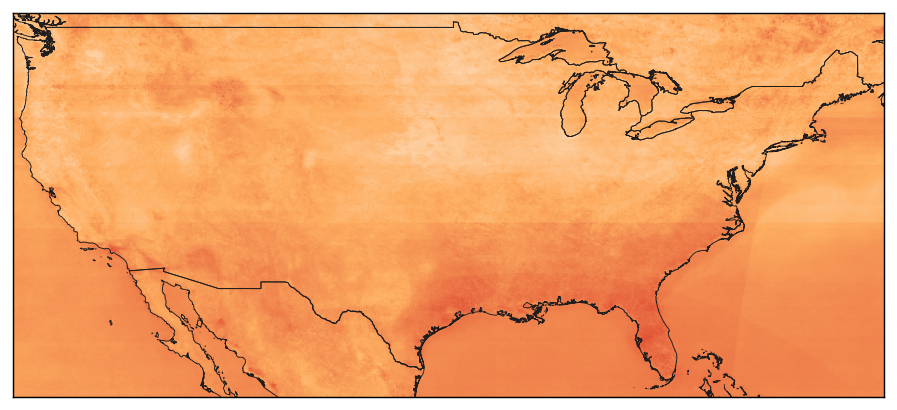

In [31]:
fig, ax = plt.subplots(figsize=(7.0, 4), dpi=130)

colors = ["#FFFFFF","#fdae61","#d73027"]
#colors = ["#FFFFFF","#fdae61","#d73027"]
cmap = LinearSegmentedColormap.from_list("w-b-g-y-o-r", colors, N=256)

im = ax.imshow(
    grid.values, origin="lower",
    extent=[lon_vals.min(), lon_vals.max(), lat_vals.min(), lat_vals.max()],
    aspect="auto",
    cmap=cmap, zorder=1, vmin=7, vmax=8.5
)

world.plot(ax=ax, color="none", edgecolor="#1F1D1D", linewidth=0.5, zorder=3)

ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

ax.set_xlim(lon_vals.min(), lon_vals.max())
ax.set_ylim(lat_vals.min(), lat_vals.max())
ax.tick_params(axis='both', which='major', labelsize=10)

lon_min, lon_max = -125, -66
lat_min, lat_max = 24, 50
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)

ax.set_xlabel("")
ax.set_ylabel("")

ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.show()

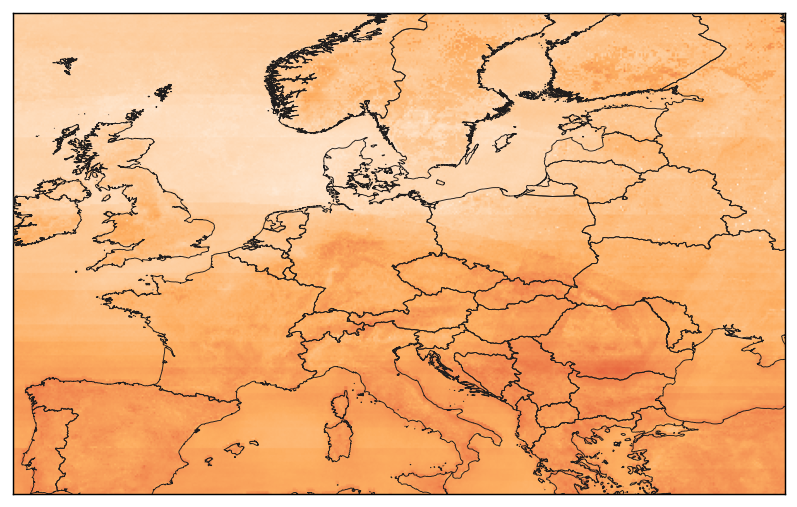

In [32]:
fig, ax = plt.subplots(figsize=(7.0, 4), dpi=130)

colors = ["#FFFFFF","#fdae61","#d73027"]
#colors = ["#FFFFFF","#fdae61","#d73027"]
cmap = LinearSegmentedColormap.from_list("w-b-g-y-o-r", colors, N=256)

im = ax.imshow(
    grid.values, origin="lower",
    extent=[lon_vals.min(), lon_vals.max(), lat_vals.min(), lat_vals.max()],
    aspect="auto",
    cmap=cmap, zorder=1, vmin=7, vmax=8.5
)

world.plot(ax=ax, color="none", edgecolor="#1F1D1D", linewidth=0.5, zorder=3)

ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

ax.set_xlim(lon_vals.min(), lon_vals.max())
ax.set_ylim(lat_vals.min(), lat_vals.max())
ax.tick_params(axis='both', which='major', labelsize=10)

lon_min, lon_max = -10, 35
lat_min, lat_max = 37, 65
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)

ax.set_xlabel("")
ax.set_ylabel("")

ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.show()

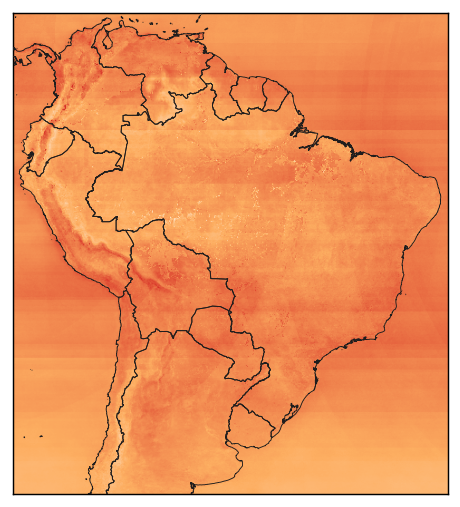

In [33]:
fig, ax = plt.subplots(figsize=(7.0, 4), dpi=130)

colors = ["#FFFFFF","#fdae61","#d73027"]
#colors = ["#FFFFFF","#fdae61","#d73027"]
cmap = LinearSegmentedColormap.from_list("w-b-g-y-o-r", colors, N=256)

im = ax.imshow(
    grid.values, origin="lower",
    extent=[lon_vals.min(), lon_vals.max(), lat_vals.min(), lat_vals.max()],
    aspect="auto",
    cmap=cmap, zorder=1, vmin=7, vmax=8.5
)

world.plot(ax=ax, color="none", edgecolor="#1F1D1D", linewidth=0.5, zorder=3)

ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

ax.set_xlim(lon_vals.min(), lon_vals.max())
ax.set_ylim(lat_vals.min(), lat_vals.max())
ax.tick_params(axis='both', which='major', labelsize=10)

lon_min, lon_max = -82, -34   
lat_min, lat_max = -40, 13
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)

ax.set_xlabel("")
ax.set_ylabel("")

ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.show()

## **3.2 Plot 2020-2019**

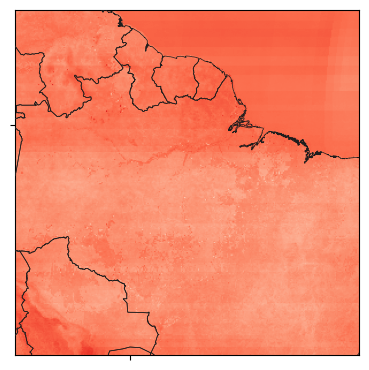

In [ ]:
def load_mean_year(year, folder="../plot_trend_XCO2"):
    path = os.path.join(folder, f"mean_{year}.npy")
    arr = np.load(path, allow_pickle=True)
    df = pd.DataFrame.from_records(arr)
    for c in ["lat", "lon", f"xco2_{year}"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
        else:
            raise ValueError(f"{path} 缺少列: {c}")
    return df

mean_2019 = load_mean_year(2019)
mean_2020 = load_mean_year(2020)

merged = mean_2019.merge(mean_2020, on=["lat", "lon"], how="inner")
merged["trend_ppm_per_year"] = (merged["xco2_2020"] - merged["xco2_2019"]) /1  
grid = merged.pivot(index="lat", columns="lon", values="trend_ppm_per_year").sort_index()

world = gpd.read_file("../world/admin_world_country.shp")
world = world.set_crs(epsg=4326) if world.crs is None else world.to_crs(epsg=4326)

lat_vals = grid.index.values
lon_vals = grid.columns.values

def fmt_lon(x, pos):
    if np.isnan(x): 
        return ""
    if x == 0:
        return "0°"
    hemi = "W" if x < 0 else "E"
    return f"{abs(x):.0f}°{hemi}"

def fmt_lat(y, pos):
    if np.isnan(y): 
        return ""
    if y == 0:
        return "0°"
    hemi = "S" if y < 0 else "N"
    return f"{abs(y):.0f}°{hemi}"

lon_formatter = FuncFormatter(fmt_lon)
lat_formatter = FuncFormatter(fmt_lat)

def nice_ticks(vmin, vmax, step):
    start = np.ceil(vmin / step) * step
    end   = np.floor(vmax / step) * step
    return np.arange(start, end + 1e-9, step)

xticks = nice_ticks(lon_vals.min(), lon_vals.max(), 60) 
yticks = nice_ticks(lat_vals.min(), lat_vals.max(), 30) 

fig, ax = plt.subplots(figsize=(7.0, 3.8))

im = ax.imshow(
    grid.values, origin="lower",
    extent=[lon_vals.min(), lon_vals.max(), lat_vals.min(), lat_vals.max()],
    aspect="auto",
    cmap=cmap, zorder=1, vmin=1, vmax=4
)

world.plot(ax=ax, color="none", edgecolor="#1F1D1D", linewidth=0.5, zorder=3)

ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_xlabel("")
ax.set_ylabel("")

ax.set_xlim(lon_vals.min(), lon_vals.max())
ax.set_ylim(lat_vals.min(), lat_vals.max())
ax.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()
plt.show()

## **3.3 Plot 2021-2020**

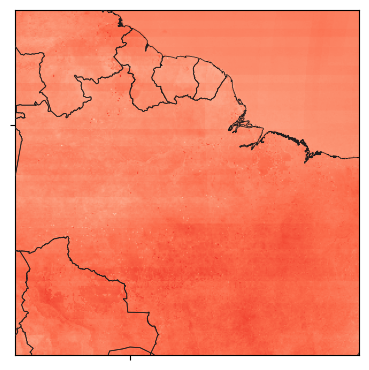

In [ ]:
def load_mean_year(year, folder="../plot_trend_XCO2"):
    path = os.path.join(folder, f"mean_{year}.npy")
    arr = np.load(path, allow_pickle=True)
    df = pd.DataFrame.from_records(arr)
    for c in ["lat", "lon", f"xco2_{year}"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
        else:
            raise ValueError(f"{path} 缺少列: {c}")
    return df

mean_2019 = load_mean_year(2020)
mean_2020 = load_mean_year(2021)

merged = mean_2019.merge(mean_2020, on=["lat", "lon"], how="inner")
merged["trend_ppm_per_year"] = (merged["xco2_2021"] - merged["xco2_2020"]) /1  
grid = merged.pivot(index="lat", columns="lon", values="trend_ppm_per_year").sort_index()

world = gpd.read_file("../world/admin_world_country.shp")
world = world.set_crs(epsg=4326) if world.crs is None else world.to_crs(epsg=4326)

lat_vals = grid.index.values
lon_vals = grid.columns.values

def fmt_lon(x, pos):
    if np.isnan(x): 
        return ""
    if x == 0:
        return "0°"
    hemi = "W" if x < 0 else "E"
    return f"{abs(x):.0f}°{hemi}"

def fmt_lat(y, pos):
    if np.isnan(y): 
        return ""
    if y == 0:
        return "0°"
    hemi = "S" if y < 0 else "N"
    return f"{abs(y):.0f}°{hemi}"

lon_formatter = FuncFormatter(fmt_lon)
lat_formatter = FuncFormatter(fmt_lat)

def nice_ticks(vmin, vmax, step):
    start = np.ceil(vmin / step) * step
    end   = np.floor(vmax / step) * step
    return np.arange(start, end + 1e-9, step)

xticks = nice_ticks(lon_vals.min(), lon_vals.max(), 60) 
yticks = nice_ticks(lat_vals.min(), lat_vals.max(), 30) 

fig, ax = plt.subplots(figsize=(7.0, 3.8))

im = ax.imshow(
    grid.values, origin="lower",
    extent=[lon_vals.min(), lon_vals.max(), lat_vals.min(), lat_vals.max()],
    aspect="auto",
    cmap=cmap, zorder=1, vmin=1, vmax=4
)

world.plot(ax=ax, color="none", edgecolor="#1F1D1D", linewidth=0.5, zorder=3)

ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_xlabel("")
ax.set_ylabel("")

ax.set_xlim(lon_vals.min(), lon_vals.max())
ax.set_ylim(lat_vals.min(), lat_vals.max())
ax.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()
plt.show()

## **3.4 Plot 2022-2021**

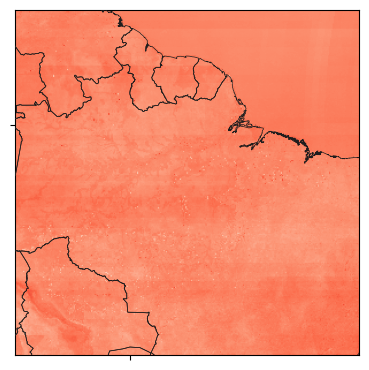

In [ ]:
def load_mean_year(year, folder="../plot_trend_XCO2"):
    path = os.path.join(folder, f"mean_{year}.npy")
    arr = np.load(path, allow_pickle=True)
    df = pd.DataFrame.from_records(arr) 
    for c in ["lat", "lon", f"xco2_{year}"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
        else:
            raise ValueError(f"{path} 缺少列: {c}")
    return df

mean_2019 = load_mean_year(2021)
mean_2020 = load_mean_year(2022)

merged = mean_2019.merge(mean_2020, on=["lat", "lon"], how="inner")
merged["trend_ppm_per_year"] = (merged["xco2_2022"] - merged["xco2_2021"]) /1 
grid = merged.pivot(index="lat", columns="lon", values="trend_ppm_per_year").sort_index()

world = gpd.read_file("../world/admin_world_country.shp")
world = world.set_crs(epsg=4326) if world.crs is None else world.to_crs(epsg=4326)

lat_vals = grid.index.values
lon_vals = grid.columns.values

def fmt_lon(x, pos):
    if np.isnan(x): 
        return ""
    if x == 0:
        return "0°"
    hemi = "W" if x < 0 else "E"
    return f"{abs(x):.0f}°{hemi}"

def fmt_lat(y, pos):
    if np.isnan(y): 
        return ""
    if y == 0:
        return "0°"
    hemi = "S" if y < 0 else "N"
    return f"{abs(y):.0f}°{hemi}"

lon_formatter = FuncFormatter(fmt_lon)
lat_formatter = FuncFormatter(fmt_lat)

def nice_ticks(vmin, vmax, step):
    start = np.ceil(vmin / step) * step
    end   = np.floor(vmax / step) * step
    return np.arange(start, end + 1e-9, step)

xticks = nice_ticks(lon_vals.min(), lon_vals.max(), 60) 
yticks = nice_ticks(lat_vals.min(), lat_vals.max(), 30) 

fig, ax = plt.subplots(figsize=(7.0, 3.8))

im = ax.imshow(
    grid.values, origin="lower",
    extent=[lon_vals.min(), lon_vals.max(), lat_vals.min(), lat_vals.max()],
    aspect="auto",
    cmap=cmap, zorder=1, vmin=1, vmax=4
)

world.plot(ax=ax, color="none", edgecolor="#1F1D1D", linewidth=0.5, zorder=3)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xlim(lon_vals.min(), lon_vals.max())
ax.set_ylim(lat_vals.min(), lat_vals.max())
ax.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()
plt.show()

## **3.5 Plot 2023-2022**

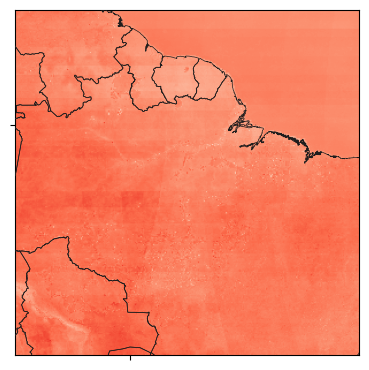

In [ ]:
def load_mean_year(year, folder="../plot_trend_XCO2"):
    path = os.path.join(folder, f"mean_{year}.npy")
    arr = np.load(path, allow_pickle=True)
    df = pd.DataFrame.from_records(arr) 
    for c in ["lat", "lon", f"xco2_{year}"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
        else:
            raise ValueError(f"{path} 缺少列: {c}")
    return df

mean_2019 = load_mean_year(2022)
mean_2020 = load_mean_year(2023)

merged = mean_2019.merge(mean_2020, on=["lat", "lon"], how="inner")
merged["trend_ppm_per_year"] = (merged["xco2_2023"] - merged["xco2_2022"]) /1 
grid = merged.pivot(index="lat", columns="lon", values="trend_ppm_per_year").sort_index()

world = gpd.read_file("../world/admin_world_country.shp")
world = world.set_crs(epsg=4326) if world.crs is None else world.to_crs(epsg=4326)

lat_vals = grid.index.values
lon_vals = grid.columns.values

def fmt_lon(x, pos):
    if np.isnan(x): 
        return ""
    if x == 0:
        return "0°"
    hemi = "W" if x < 0 else "E"
    return f"{abs(x):.0f}°{hemi}"

def fmt_lat(y, pos):
    if np.isnan(y): 
        return ""
    if y == 0:
        return "0°"
    hemi = "S" if y < 0 else "N"
    return f"{abs(y):.0f}°{hemi}"

lon_formatter = FuncFormatter(fmt_lon)
lat_formatter = FuncFormatter(fmt_lat)

def nice_ticks(vmin, vmax, step):
    start = np.ceil(vmin / step) * step
    end   = np.floor(vmax / step) * step
    return np.arange(start, end + 1e-9, step)

xticks = nice_ticks(lon_vals.min(), lon_vals.max(), 60) 
yticks = nice_ticks(lat_vals.min(), lat_vals.max(), 30) 

fig, ax = plt.subplots(figsize=(7.0, 3.8))
im = ax.imshow(
    grid.values, origin="lower",
    extent=[lon_vals.min(), lon_vals.max(), lat_vals.min(), lat_vals.max()],
    aspect="auto",
    cmap=cmap, zorder=1, vmin=1, vmax=4
)

world.plot(ax=ax, color="none", edgecolor="#1F1D1D", linewidth=0.5, zorder=3)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xlim(lon_vals.min(), lon_vals.max())
ax.set_ylim(lat_vals.min(), lat_vals.max())
ax.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()
plt.show()

## **3.6 Plot 2024-2023**

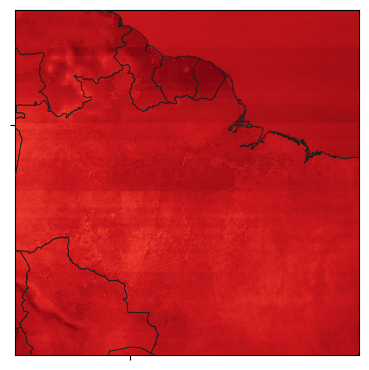

In [ ]:
def load_mean_year(year, folder="../plot_trend_XCO2"):
    path = os.path.join(folder, f"mean_{year}.npy")
    arr = np.load(path, allow_pickle=True)
    df = pd.DataFrame.from_records(arr) 
    for c in ["lat", "lon", f"xco2_{year}"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
        else:
            raise ValueError(f"{path} 缺少列: {c}")
    return df

mean_2019 = load_mean_year(2023)
mean_2020 = load_mean_year(2024)

merged = mean_2019.merge(mean_2020, on=["lat", "lon"], how="inner")
merged["trend_ppm_per_year"] = (merged["xco2_2024"] - merged["xco2_2023"]) /1 
grid = merged.pivot(index="lat", columns="lon", values="trend_ppm_per_year").sort_index()

world = gpd.read_file("../world/admin_world_country.shp")
world = world.set_crs(epsg=4326) if world.crs is None else world.to_crs(epsg=4326)

lat_vals = grid.index.values
lon_vals = grid.columns.values

def fmt_lon(x, pos):
    if np.isnan(x): 
        return ""
    if x == 0:
        return "0°"
    hemi = "W" if x < 0 else "E"
    return f"{abs(x):.0f}°{hemi}"

def fmt_lat(y, pos):
    if np.isnan(y): 
        return ""
    if y == 0:
        return "0°"
    hemi = "S" if y < 0 else "N"
    return f"{abs(y):.0f}°{hemi}"

lon_formatter = FuncFormatter(fmt_lon)
lat_formatter = FuncFormatter(fmt_lat)

def nice_ticks(vmin, vmax, step):
    start = np.ceil(vmin / step) * step
    end   = np.floor(vmax / step) * step
    return np.arange(start, end + 1e-9, step)

xticks = nice_ticks(lon_vals.min(), lon_vals.max(), 60)
yticks = nice_ticks(lat_vals.min(), lat_vals.max(), 30) 

fig, ax = plt.subplots(figsize=(7.0, 3.8))

im = ax.imshow(
    grid.values, origin="lower",
    extent=[lon_vals.min(), lon_vals.max(), lat_vals.min(), lat_vals.max()],
    aspect="auto",
    cmap=cmap, zorder=1, vmin=1, vmax=4
)

world.plot(ax=ax, color="none", edgecolor="#1F1D1D", linewidth=0.5, zorder=3)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xlim(lon_vals.min(), lon_vals.max())
ax.set_ylim(lat_vals.min(), lat_vals.max())
ax.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()
plt.show()

## **3.7 Plot 2025-2024**

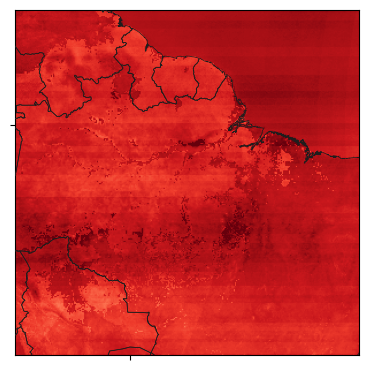

In [ ]:
def load_mean_year(year, folder="../plot_trend_XCO2"):
    path = os.path.join(folder, f"mean_{year}_JanMay.npy")
    arr = np.load(path, allow_pickle=True)
    df = pd.DataFrame.from_records(arr) 
    for c in ["lat", "lon", f"xco2_{year}_m01_02_03_04_05"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
        else:
            raise ValueError(f"{path} 缺少列: {c}")
    return df

mean_2019 = load_mean_year(2024)
mean_2020 = load_mean_year(2025)

merged = mean_2019.merge(mean_2020, on=["lat", "lon"], how="inner")
merged["trend_ppm_per_year"] = (merged["xco2_2025_m01_02_03_04_05"] - merged["xco2_2024_m01_02_03_04_05"]) /1
grid = merged.pivot(index="lat", columns="lon", values="trend_ppm_per_year").sort_index()

world = gpd.read_file("../world/admin_world_country.shp")
world = world.set_crs(epsg=4326) if world.crs is None else world.to_crs(epsg=4326)

lat_vals = grid.index.values
lon_vals = grid.columns.values

def fmt_lon(x, pos):
    if np.isnan(x): 
        return ""
    if x == 0:
        return "0°"
    hemi = "W" if x < 0 else "E"
    return f"{abs(x):.0f}°{hemi}"

def fmt_lat(y, pos):
    if np.isnan(y): 
        return ""
    if y == 0:
        return "0°"
    hemi = "S" if y < 0 else "N"
    return f"{abs(y):.0f}°{hemi}"

lon_formatter = FuncFormatter(fmt_lon)
lat_formatter = FuncFormatter(fmt_lat)

def nice_ticks(vmin, vmax, step):
    start = np.ceil(vmin / step) * step
    end   = np.floor(vmax / step) * step
    return np.arange(start, end + 1e-9, step)

xticks = nice_ticks(lon_vals.min(), lon_vals.max(), 60)
yticks = nice_ticks(lat_vals.min(), lat_vals.max(), 30) 

fig, ax = plt.subplots(figsize=(7.0, 3.8))
im = ax.imshow(
    grid.values, origin="lower",
    extent=[lon_vals.min(), lon_vals.max(), lat_vals.min(), lat_vals.max()],
    aspect="auto",
    cmap=cmap, zorder=1, vmin=1, vmax=4
)
world.plot(ax=ax, color="none", edgecolor="#1F1D1D", linewidth=0.5, zorder=3)

ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xlim(lon_vals.min(), lon_vals.max())
ax.set_ylim(lat_vals.min(), lat_vals.max())
ax.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()
plt.show()

## **3.8 Plot Colorbar**

In [ ]:
fig_cb, ax_cb = plt.subplots(figsize=(0.15, 4.5), dpi=200)
cbar = fig_cb.colorbar(im, cax=ax_cb, orientation="vertical")
cbar.set_label("XCO$_2$ Trend (ppm/year)")

plt.tight_layout()
plt.show()

# **4. Plot daily change**

## **4.1 Transfer: Calculate the daily change (mean and std)**

In [ ]:
DATA_DIR      = "../XCO2_prediction_full"
GLOB_PATTERN  = os.path.join(DATA_DIR, "monthly_xco2_full_*.npy")
START_DATE    = "2019-01-01"
END_DATE      = "2025-05-31"
USE_WEIGHTS   = False
OUTPUT_DIR    = os.path.join(DATA_DIR, "global_daily_output")
os.makedirs(OUTPUT_DIR, exist_ok=True)

accum_dict = {} 

def load_month_file(path):
    arr = np.load(path, allow_pickle=True)
    df = pd.DataFrame(arr)[["lat", "lon", "time", "xco2_pred"]].copy()
    df["time"] = pd.to_datetime(df["time"], errors="coerce")
    df = df[(df["time"] >= START_DATE) & (df["time"] <= END_DATE)]
    df["date"] = df["time"].dt.floor("D")
    return df[["lat", "lon", "date", "xco2_pred"]].dropna().reset_index(drop=True)

files = sorted(glob.glob(GLOB_PATTERN))
if not files:
    raise FileNotFoundError(f"Cannot find files：{GLOB_PATTERN}")

for f in tqdm(files, desc="Processing month files", unit="file"):
    df_cur = load_month_file(f)
    if df_cur.empty:
        continue
    year = pd.to_datetime(df_cur["date"].iloc[0]).year
    prev_year = year - 1

    prev_candidates = [p for p in files if str(prev_year) in os.path.basename(p)]
    if not prev_candidates:
        continue 
    df_prev = load_month_file(prev_candidates[0])
    if df_prev.empty:
        continue
    df_cur["md"]  = df_cur["date"].dt.strftime("%m-%d")
    df_prev["md"] = df_prev["date"].dt.strftime("%m-%d")

    merged = df_cur.merge(df_prev, on=["lat", "lon", "md"], suffixes=("_cur", "_prev"))
    if merged.empty:
        continue

    merged["date"] = df_cur["date"].iloc[0].replace(year=year)
    merged["delta"] = merged["xco2_pred_cur"] - merged["xco2_pred_prev"]
    merged["w"] = np.cos(np.deg2rad(np.abs(merged["lat"]))) if USE_WEIGHTS else 1.0

    for date_i, g in merged.groupby("date"):
        w  = g["w"].to_numpy(dtype=float)
        dx = g["delta"].to_numpy(dtype=float)
        wx = w * dx
        wx2 = w * (dx ** 2)
        n = len(dx)

        if date_i not in accum_dict:
            accum_dict[date_i] = {"wx_sum": 0.0, "w_sum": 0.0, "wx2_sum": 0.0, "n": 0}

        accum_dict[date_i]["wx_sum"] += wx.sum()
        accum_dict[date_i]["w_sum"]  += w.sum()
        accum_dict[date_i]["wx2_sum"] += wx2.sum()
        accum_dict[date_i]["n"]      += n

dates_sorted = sorted(accum_dict.keys())
records = []

for d in dates_sorted:
    v = accum_dict[d]
    if v["w_sum"] == 0 or v["n"] == 0:
        continue
    mean = v["wx_sum"] / v["w_sum"]
    var  = (v["wx2_sum"] / v["w_sum"]) - mean**2
    std  = np.sqrt(max(var, 0))
    records.append([d, mean, std, v["n"]])

global_daily = pd.DataFrame(records, columns=["date", "delta_mean", "delta_std", "n_cells"])
global_daily = global_daily.sort_values("date").reset_index(drop=True)

print(global_daily.head())
print(global_daily.tail())

weight_flag = "weighted" if USE_WEIGHTS else "unweighted"
out_npy = os.path.join(OUTPUT_DIR, f"global_daily_xco2_yoydelta_{weight_flag}_stream.npy")

out_dict = {
    "date": global_daily["date"].to_numpy(dtype="datetime64[D]"),
    "delta_mean": global_daily["delta_mean"].to_numpy(dtype="float64"),
    "delta_std": global_daily["delta_std"].to_numpy(dtype="float64"),
    "n_cells": global_daily["n_cells"].to_numpy(dtype="int64")
}
np.save(out_npy, np.array(out_dict, dtype=object))
print("✅ Saved:", out_npy)

## **4.2 Transfer raw data to daily mean and save**

In [ ]:
DATA_DIR      = "../XCO2_prediction_full"      
GLOB_PATTERN  = os.path.join(DATA_DIR, "monthly_xco2_full_*.npy")
START_DATE    = "2019-01-01"
END_DATE      = "2025-05-31"
USE_WEIGHTS   = True  
OUTPUT_DIR    = os.path.join(DATA_DIR, "global_daily_output")
os.makedirs(OUTPUT_DIR, exist_ok=True)

def load_npy_to_df(npy_path):
    arr = np.load(npy_path, allow_pickle=True)
    df = pd.DataFrame(arr)

    lat_col   = "lat"
    lon_col   = "lon"
    time_col  = "time"
    x_col     = "xco2_pred"

    out = df[[lat_col, lon_col, time_col, x_col]].copy()
    out["time"] = pd.to_datetime(out["time"], errors="coerce")

    if START_DATE:
        out = out[out["time"] >= pd.to_datetime(START_DATE)]
    if END_DATE:
        out = out[out["time"] <= pd.to_datetime(END_DATE)]

    return out.reset_index(drop=True)

def weighted_daily_stats(df_day):
    w = np.cos(np.deg2rad(np.abs(df_day["lat"].to_numpy(dtype=float))))
    x = df_day["xco2_pred"].to_numpy(dtype=float)

    W = np.sum(w)
    if W == 0 or np.isnan(W):
        return np.nan, np.nan

    mean = np.sum(w * x) / W
    var  = np.sum(w * (x - mean)**2) / W
    var  = max(var, 0.0) 
    std  = np.sqrt(var)

    return mean, std

daily_chunks = [] 

files = sorted(glob.glob(GLOB_PATTERN))
if not files:
    raise FileNotFoundError(f"can not find：{GLOB_PATTERN}")

for f in tqdm(files, desc="Computing global daily means/std", unit="file"):
    df = load_npy_to_df(f)
    if df.empty:
        continue

    df["date"] = df["time"].dt.floor("D")

    if USE_WEIGHTS:
        stats_list = []
        for date, group in df.groupby("date"):
            mean, std = weighted_daily_stats(group)
            stats_list.append({"date": date,
                               "xco2_global_mean": mean,
                               "xco2_global_std": std})
        g = pd.DataFrame(stats_list)
    else:
        g = (df.groupby("date")["xco2_pred"]
               .agg(xco2_global_mean="mean", xco2_global_std="std")
               .reset_index())

    daily_chunks.append(g)

global_daily = (pd.concat(daily_chunks, axis=0, ignore_index=True)
                  .groupby("date", as_index=False)
                  .agg(xco2_global_mean=("xco2_global_mean", "mean"),
                       xco2_global_std=("xco2_global_std", "mean"))
                  .sort_values("date")
                  .reset_index(drop=True))

print(global_daily.head())
print(global_daily.tail())

out_npy = os.path.join(
    OUTPUT_DIR,
    f"global_daily_xco2_{'weighted' if USE_WEIGHTS else 'unweighted'}_2019_2025.npy"
)

np.save(
    out_npy,
    np.array({
        "date": global_daily["date"].to_numpy(dtype="datetime64[D]"),
        "xco2_global_mean": global_daily["xco2_global_mean"].to_numpy(dtype="float64"),
        "xco2_global_std":  global_daily["xco2_global_std"].to_numpy(dtype="float64"),
    }, dtype=object)
)

print("✅ NPY saved:", out_npy)

## **4.3 Load saved data**

In [3]:
USE_WEIGHTS = True 

DATA_DIR      = "../XCO2_prediction_full"    
OUTPUT_DIR    = os.path.join(DATA_DIR, "global_daily_output")

out_npy = os.path.join(
    OUTPUT_DIR,
    f"global_daily_xco2_{'weighted' if USE_WEIGHTS else 'unweighted'}_2019_2025.npy"
)

arr = np.load(out_npy, allow_pickle=True)

data_dict = arr.item() 

dates = data_dict["date"]   
xco2  = data_dict["xco2_global_mean"] 

if "xco2_global_std" in data_dict:
    xco2_std = data_dict["xco2_global_std"]
else:

    xco2_std = np.full_like(xco2, np.nan, dtype=float)

global_daily = pd.DataFrame({
    "date": dates,
    "xco2_global_mean": xco2,
    "xco2_global_std": xco2_std,
})

global_daily

date  xco2_global_mean  xco2_global_std
0    2019-01-01        407.757909         1.970421
1    2019-01-02        407.753364         1.988764
2    2019-01-03        407.795655         1.994958
3    2019-01-04        407.792023         2.021794
4    2019-01-05        407.847829         2.028179
...         ...               ...              ...
2338 2025-05-27        425.161952         2.740240
2339 2025-05-28        425.148041         2.712561
2340 2025-05-29        425.133722         2.692104
2341 2025-05-30        425.149260         2.696802
2342 2025-05-31        425.086413         2.752655

[2343 rows x 3 columns]

## **4.4 Plot Figures**

Max DOY by year: {2019: 365, 2020: 366, 2021: 365, 2022: 365, 2023: 365, 2024: 366, 2025: 151}


/tmp/ipykernel_13920/2405400037.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  reds = cm.get_cmap('Reds')


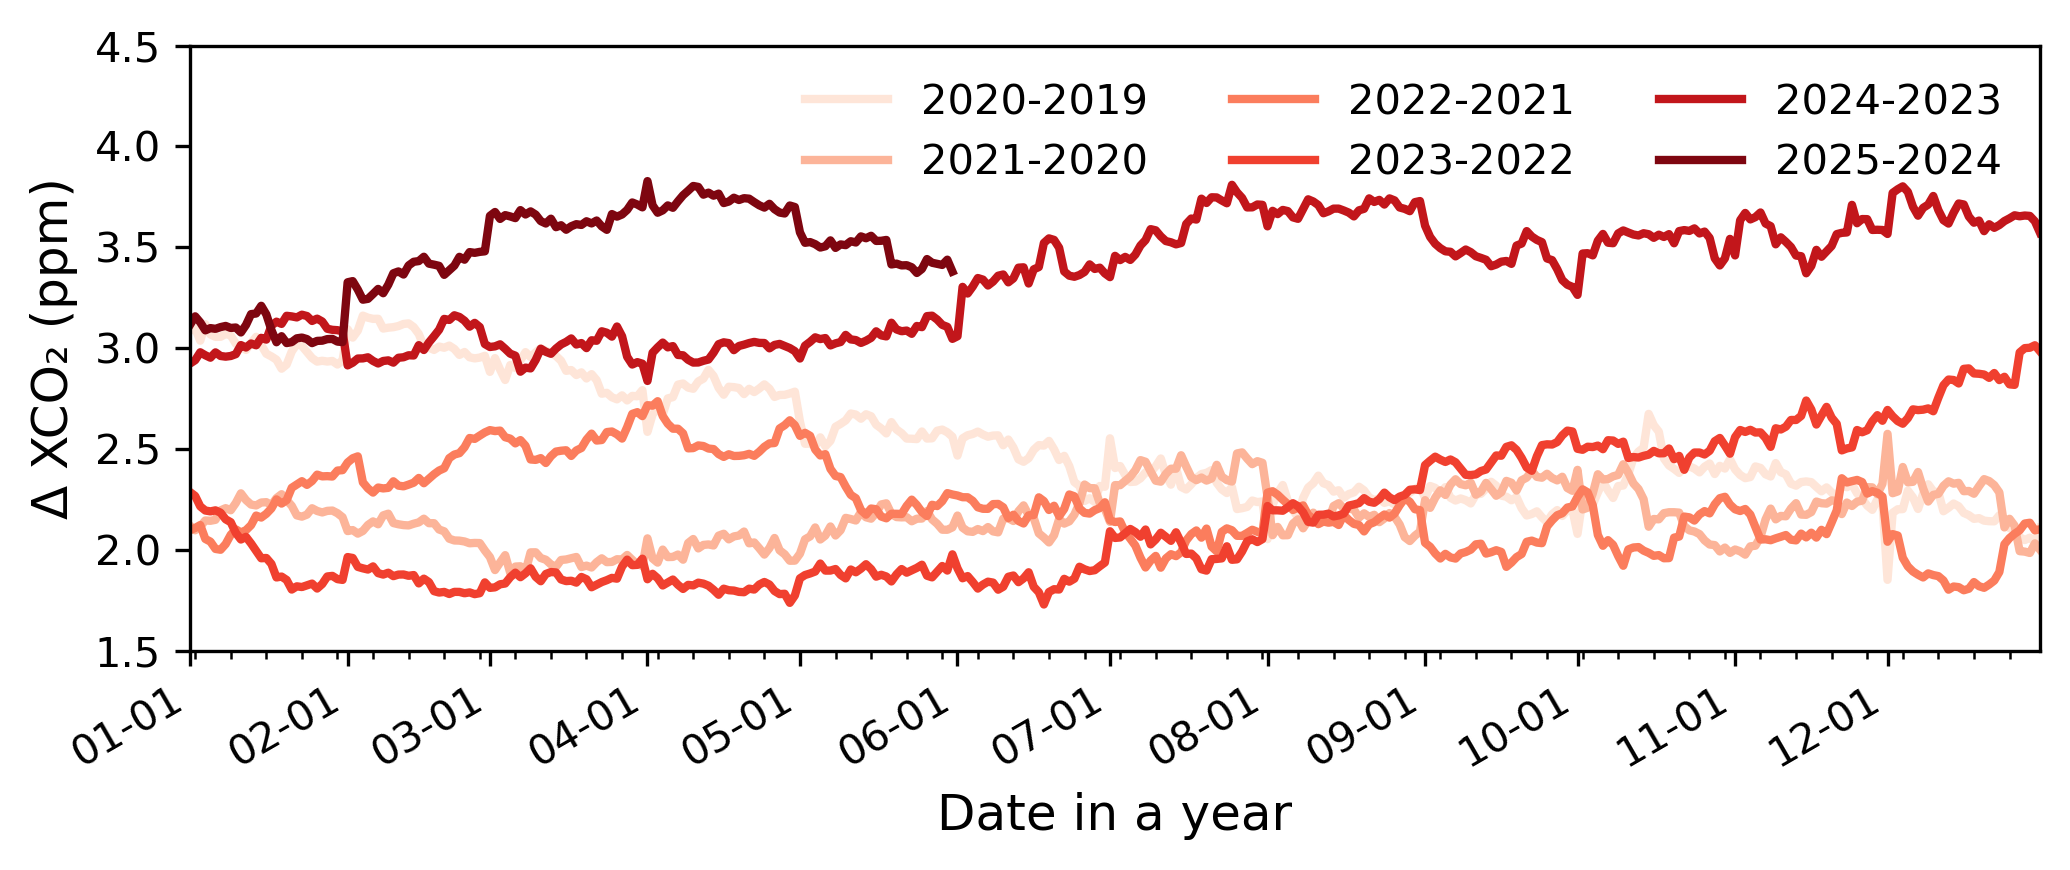

In [4]:
df = global_daily.copy()
df['date'] = pd.to_datetime(df['date'])
df = df[~((df['date'].dt.month == 2) & (df['date'].dt.day == 29))].copy()

df['year'] = df['date'].dt.year
df['doy']  = df['date'].dt.dayofyear 

df = df[df['year'].between(2019, 2025)]

max_doy_by_year = df.groupby('year')['doy'].max().to_dict()
print("Max DOY by year:", max_doy_by_year)

pivot = df.pivot(index='doy', columns='year', values='xco2_global_mean').sort_index()

pivot = pivot.reindex(range(1, 366))
pivot = pivot.interpolate(limit_direction='both')

year_pairs = [
    (2020, 2019),
    (2021, 2020),
    (2022, 2021),
    (2023, 2022),
    (2024, 2023),
    (2025, 2024),  
]

diff_series = {}
for (y1, y0) in year_pairs:
    diff = pivot[y1] - pivot[y0]
    max_valid_doy = max_doy_by_year.get(y1, 365)
    diff.loc[diff.index > max_valid_doy] = np.nan
    diff_series[f"{y1}-{y0}"] = diff

reds = cm.get_cmap('Reds')
colors = [reds(v) for v in np.linspace(0.1, 0.95, len(year_pairs))]

date_index = pd.date_range("2001-01-01", periods=365, freq="D") 

fig, ax = plt.subplots(figsize=(7, 3), dpi=300)

for (label, color) in zip(diff_series.keys(), colors):
    ax.plot(date_index, diff_series[label].values, label=label, lw=2.0, color=color)

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
ax.xaxis.set_minor_locator(mdates.WeekdayLocator())

ax.set_xlim(date_index.min(), date_index.max())
ax.set_xlabel("Date in a year", fontsize=12)
ax.set_ylabel("Δ XCO₂ (ppm)", fontsize=12)
#ax.grid(True, which="major", alpha=0.3, linestyle="--", linewidth=0.7)
ax.legend(ncol=3, frameon=False, fontsize=10, title_fontsize=11)
fig.autofmt_xdate()
ax.set_ylim(1.5, 4.5)
plt.tight_layout()
plt.show()

In [ ]:
THRESH = 3.0
label_target = "2024-2023"

s = diff_series[label_target].copy()

valid = s.dropna()
n_valid = valid.size 

mask = valid > THRESH
n_exceed = int(mask.sum()) 

pct_exceed = (n_exceed / n_valid * 100.0) if n_valid > 0 else np.nan

print(f"[{label_target}] valid days = {n_valid}")
print(f"[{label_target}] days with ΔXCO₂ > {THRESH} ppm = {n_exceed}")
print(f"[{label_target}] fraction = {pct_exceed:.2f}%")

exceed_doys = valid.index[mask]  
exceed_dates = date_index[exceed_doys - 1] 
print("First 20 exceed dates (mm-dd):", exceed_dates.strftime("%m-%d")[:20].tolist())

[2024-2023] valid days = 365
[2024-2023] days with ΔXCO₂ > 3.0 ppm = 311
[2024-2023] fraction = 85.21%
First 20 exceed dates (mm-dd): ['01-11', '01-12', '01-13', '01-14', '01-15', '01-16', '01-17', '01-18', '01-19', '01-20', '01-21', '01-22', '01-23', '01-24', '01-25', '01-26', '01-27', '01-28', '01-29', '01-30']
